EL objetivo de este programa es modelar con regresión lineal las calificaciones
 obtenidas por un alumno con las variables del dataset. En otras palabras buscamos los coeficientes a_{n} tal que y=a_{1}x_{1} + .....+ a_{n}x_{n}.

In [193]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import matplotlib.pyplot as plt

El paso siguientes es usar la Api para poder ir directamente al conjunto de datos de la pagina kaggle.

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

In [195]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d nikhil7280/student-performance-multiple-linear-regression
!chmod 600 /root/.kaggle/kaggle.json

In [197]:
df=pd.read_csv("/content/student-performance-multiple-linear-regression.zip")

In [198]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Observamos que el dataset no tiene datos faltantes y además los datos son enteros, por lo que podemos usarlos fácilmente en el modelo de regresión, a excepción de la columna de actividades extracurriculares.

In [199]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

Creamos un variable dummy para poder categorizar la columna de actividades extracurriculares, como son valores booleanos podemos ver que la categorización usará los valores de 0 y 1.

In [200]:
dummys_Extracular=pd.get_dummies(df["Extracurricular Activities"], prefix="Ex_Ac")

In [201]:
df_2=df.join(dummys_Extracular)

Podemos obvservar tres garficas de forma de pastel para poder entender mejor nuestros datos.

Nota: solo se grafica de estas 3 columnas, pues son las unicas con un numero de valores distinto menor a 10, para poder evitar la sobresaturación en el grafico.

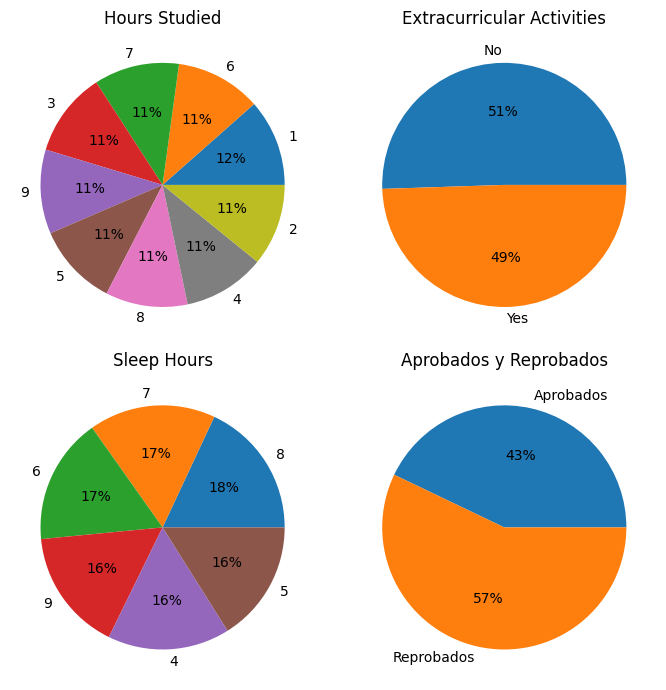

In [290]:
aprobados_data = df_2["Performance Index"] >= 60
reprobados_data = df_2["Performance Index"] < 60

suma = [aprobados_data.sum(), reprobados_data.sum()]
etiquetas = ["Aprobados", "Reprobados"]
a = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

for i in df_3.columns:
    if df_3[i].nunique() < 10:
        p = a // 2
        q = a % 2
        df1 = df_3[i].value_counts()
        ax[p, q].pie(df1, labels=df1.index, autopct='%.0f%%')
        ax[p, q].set_title(i)
        a = a + 1

p = a // 2
q = a % 2
ax[p, q].pie(suma, labels=etiquetas ,autopct='%.0f%%')
ax[p, q].set_title("Aprobados y Reprobados")

plt.tight_layout()
plt.show()

In [202]:
columns_name=df_2.columns.values.tolist()

In [203]:
columns_name.remove("Extracurricular Activities")
columns_name.remove("Performance Index")

Ya que removimos la columna objeivo(el rendimiento del alumno) y la variable que categorizamos podemos crear una lista de las columnas que nos interesan.

In [204]:
columns_name

['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Ex_Ac_No',
 'Ex_Ac_Yes']

In [205]:
X=df_2[columns_name]
Y=df_2["Performance Index"]

Usamos los algoritmos de SVR para poder saber cuales de las columnas aportarán más a nuestro modelo y las podamos rankear.

Nota: Se descubrió que el ranking no fue del todo preciso, pues nos indica que la "columna Sample Question Papers Practiced" no es tan importante como las otras, pero al momento de incluirla al modelo esta mejora notablemente las predicciones. Esto se debe a dos factores: al problema de colinealidad y al tamaño del conjunto de datos.

In [206]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X,Y)

In [207]:
selector.ranking_

array([1, 1, 1, 2, 1, 1])

In [208]:
Ranking=pd.DataFrame(list(zip(columns_name,selector.ranking_ )))
Ranking=Ranking.rename(columns={ 0: 'Columnas' })
Ranking=Ranking.rename(columns={ 1: 'Ranking' })

Creamos una tabla donde podemos observar el nombre de la columna y su importancia en el modelo.

In [209]:
Ranking

,Columnas,Ranking
0,Hours Studied,1
1,Previous Scores,1
2,Sleep Hours,1
3,Sample Question Papers Practiced,2
4,Ex_Ac_No,1
5,Ex_Ac_Yes,1


In [212]:
X_predic=["Hours Studied", "Previous Scores", "Sleep Hours", "Ex_Ac_No","Sample Question Papers Practiced"]

Creamos el modelo lineal usando sklear como lo pudo sospechar el lector en la importanción de librerias.

In [213]:
lm=LinearRegression()
lm.fit(df_2[X_predic], Y)

LinearRegression()

Podemos ver que el modelo es altamente efectivo pues el valor de 0.988 nos indica que nuestro modelo de regresión lineal se adapta perfectamente a los datos, pero lo podemos ver con la prediccion de los datos mas adelante.

In [214]:
lm.score(df_2[X_predic], Y)

0.9887523323780958

Aqui podemos ver cuales son los coeficientes que al princio advertimos que buscariamos.

In [215]:
lm.coef_, lm.intercept_

(array([ 2.85298205,  1.01843419,  0.48055975, -0.61289758,  0.19380214]),
 -33.462690509953504)

In [216]:
comparacion=pd.DataFrame(lm.predict(df_2[X_predic]))
comparacion=comparacion.rename(columns={ 0: 'Y_predic' })

In [217]:
comparacion=comparacion.join(Y)

In [218]:
errorpor=np.abs((df_2["Performance Index"]-comparacion['Y_predic'])/df_2["Performance Index"]) *100

In [222]:
comparacion["Error %"]=errorpor

En este tabla podemos ver los valores que ya se tenian registrados propios del dataset, nuestra predcción creada por nuestro modelo y el error porcentual.

In [220]:
comparacion

,Y_predic,Performance Index,Error %
0,91.852009,91.0,0.936273
1,63.157787,65.0,2.834174
2,45.052832,45.0,0.117405
3,36.551201,36.0,1.531113
4,67.091339,66.0,1.653545
...,...,...,...
9995,21.603410,23.0,6.072129
9996,56.501461,58.0,2.583688
9997,72.998729,74.0,1.353070
9998,94.366183,95.0,0.667176


In [223]:
np.mean(errorpor)

3.456448510072344

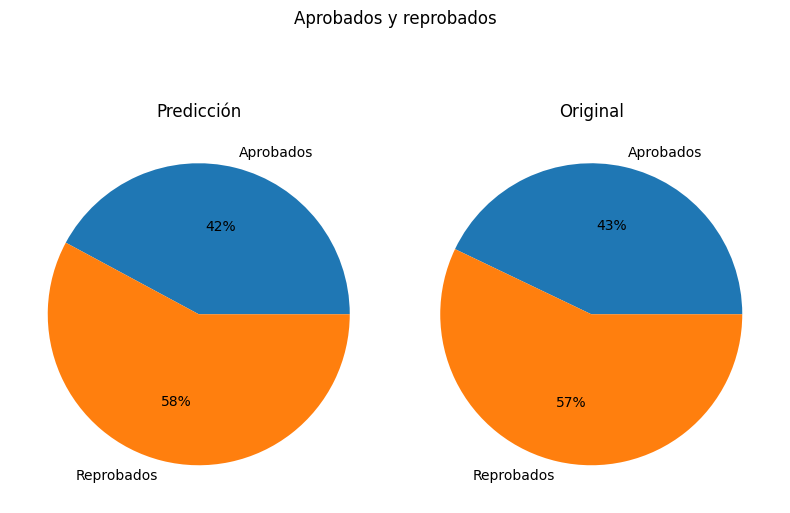

In [298]:
aprobados_data2 = comparacion["Y_predic"] >= 60
reprobados_data2 = comparacion["Y_predic"] < 60
suma2 = [aprobados_data2.sum(), reprobados_data2.sum()]

aprobados_data = df_2["Performance Index"] >= 60
reprobados_data = df_2["Performance Index"] < 60
suma = [aprobados_data.sum(), reprobados_data.sum()]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

ax[0].pie(suma2, labels=["Aprobados", "Reprobados"], autopct='%.0f%%')
ax[0].set_title("Predicción")


ax[1].pie(suma, labels=["Aprobados", "Reprobados"], autopct='%.0f%%')
ax[1].set_title("Original")

fig.suptitle("Aprobados y reprobados")

plt.tight_layout()
plt.show()


Podemos concluir que nuestro modelo de regresión lineal fue altamente efectivo, pues las predicciones tienen un error porcentual promedio del 3.45%. Esto nos puede ayudar a predecir el rendimiento de los alumnos y las oportunidades en diferentes áreas. Cabe decir que el modelo no contempla muchas variables debido al tamaño del conjunto de datos, pero eso no desmerita su gran aproximación.